In [1]:
import pickle
import numpy as np
from collections import Counter
import pprint
import copy
import matplotlib.pyplot as plt
from time import time

import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.callbacks import Callback, CSVLogger
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

## Dataset (1): build vocab, get frequency of words and length of sentences

In [2]:
with open('sentences_with_eos_and_unk.pkl', 'rb') as f:
    sentences, counter = pickle.load(f)

In [3]:
# Build vocab
vocab = sorted(counter.keys())
vocab_size = len(vocab)
print('There are %d unique words in our dataset.' % vocab_size)
num_of_words = sum(counter.values())
print('There are %d total words in our dataset.' % num_of_words)

# Hash table for words to indices and viceversa
# I don't use index 0 because it's used for padding the sequences
word_to_ix = { w:i+1 for i,w in enumerate(vocab) }
word_to_ix['<blank>'] = 0
ix_to_word = { i+1:w for i,w in enumerate(vocab) }
ix_to_word[0] = ''

There are 7274 unique words in our dataset.
There are 3380789 total words in our dataset.


In [4]:
# Get frequency of words
word_freq = np.zeros(vocab_size+1)
norm_constant = num_of_words
for i,key in enumerate(vocab):
    word_freq[i+1] = counter[key] / norm_constant
    
# Get frequency of first words
first_word_freq = np.zeros(vocab_size+1)
norm_constant = len(sentences)
for i,sentence in enumerate(sentences):
    first_word_freq[ word_to_ix[sentence.lower().split()[0]] ] += 1
first_word_freq /= len(sentences)

In [5]:
# Short analysis of length of sentences
n = 30
count_less_than_n_words = 0
maxLen = 0
counter_length = Counter([])
for sentence in sentences:
    counter_length += Counter([len(sentence.lower().split())])
    maxLen = max(maxLen,len(sentence.lower().split()))
    if len(sentence.lower().split()) >= n:
        count_less_than_n_words += 1

proportion =  (count_less_than_n_words / len(sentences)) * 100
        
print('%.2f %% of the sentences have more than %d words.' % (proportion,n)  )

3.58 % of the sentences have more than 30 words.


## Dataset (2): split train-trest, one-hot vectors, generator

In [6]:
def shuffle_and_split_training_set(sentences_original, percentage_test=2):
    # shuffle at unison
    print('Shuffling sentences')

    tmp_sentences = []
    for i in np.random.RandomState(seed=0).permutation(len(sentences_original)):
        tmp_sentences.append(sentences_original[i])

    cut_index = int(len(sentences_original) * (1.-(percentage_test/100.)))
    x_train, x_test = tmp_sentences[:cut_index], tmp_sentences[cut_index:]

    print("Size of training set = %d" % len(x_train))
    print("Size of test set = %d" % len(x_test))
    return x_train, x_test

In [7]:
sentences_train, sentences_test = shuffle_and_split_training_set(sentences)

Shuffling sentences
Size of training set = 221835
Size of test set = 4528


In [46]:
sentences_test[:20]

['Put the clips part  part and part of the loom knoop hardness test value   channel B part  the loom HB2   channel B part and the No 2 starboard igniter lead part with the bolt part and the spacers part and part in position on the oil tube part and loosely install the nut part  <eos>',
 'Put the clips part  part  part and part of the air tube part  the fuel tube part  the fuel tube part and the loom database part with the spacers part  part and part and the bolt part in position on the nut part attached to the bracket part  and loosely install the bolt part  <eos>',
 'Make sure that the ignition lever part of the door damper part and the emergency opening actuator part is in the ARMED position  <eos>',
 'You can use these pressurization sources as an alternative  or   <eos>',
 'Disconnect the electrical connectors from the 115VAC EPDC2 temporary revision 1422XZ and the 230VAC EPDC2 temporary revision 1424XZ in module 2H   <eos>',
 'Alodine 1500 mil <unk> <unk> <eos>',
 'The transducer 

When transforming to indices, we clean up: we use .lower().split()

In [9]:
def sentences_to_indices(X, word_to_ix, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros( (m, max_len) )
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        # We truncate sentence_words at max_len
        sentence_words = sentence_words[:max_len]
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words

        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in word_to_ix:
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_ix[w]
                # Increment j to j + 1
                j += 1
            
    ### END CODE HERE ###
    
    return X_indices

def convert_to_one_hot(X_indices, C):
    """
    Arguments:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    C -- size of one-hot vectors -1 place for 1 word in vocabulary, plus blank space-
    
    Returns:
    X_oh -- array of one-hot vectors corresponding to words in the sentences from X, of shape (m, max_len, C)
    """
    X_oh = np.eye(C)[X_indices]
    return X_oh

def generator(sentence_list, batch_size):
    index = 0
    while True:
        X_oh = np.zeros((batch_size, Tx, len(vocab)+1))
        Y_oh = np.zeros((batch_size, Tx, len(vocab)+1))
        
        for i in range(batch_size):
            
            # One sentences at a time
            x_indices = sentences_to_indices(np.asarray(sentence_list[index:index+1]), word_to_ix, Tx)
            X_oh[i,:,:] = convert_to_one_hot(x_indices.astype(int), C = len(vocab)+1)
        
            y_indices = np.zeros(np.shape(x_indices))
            y_indices[:,0:Tx-1] = x_indices[:,1:Tx]
            Y_oh[i,:,:] = convert_to_one_hot(y_indices.astype(int), C = len(vocab)+1)
            
            #for t, w in enumerate(sentence_list[index]):
            #    x[i, t, word_indices[w]] = 1
            #y[i, word_indices[next_word_list[index]]] = 1

            index = index + 1
            if index == len(sentence_list):
                index = 0
                
        Y_oh = np.transpose(Y_oh, (1, 0, 2))
        
        a0 = np.zeros((batch_size, n_a))
        c0 = np.zeros((batch_size, n_a))
        model_input = [X_oh, a0, c0]
        #print(np.shape(model_input))
        #print(np.shape(X_oh), np.shape(a0), np.shape(c0), np.shape(Y_oh))
        
        yield model_input, list(Y_oh)

## Define Model, optimizer, loss and metrics

#### Sequence generation uses a for-loop
* If we're building an RNN where, at test time, the entire input sequence $x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, \ldots, x^{\langle T_x \rangle}$ is given in advance, then Keras has simple built-in functions to build the model. 
* However, for **sequence generation, at test time we won't know all the values of $x^{\langle t\rangle}$ in advance**.
* Instead, we'll generate them one at a time using $x^{\langle t\rangle} = y^{\langle t-1 \rangle}$. 
    * The input at time "t" is the prediction at the previous time step "t-1".
* So we'll need to implement our own for-loop to iterate over the time steps. 

In [10]:
# Model hyperparameters
n_a = 128 # number of dimensions for the hidden state of each LSTM cell.
n_values = len(vocab) + 1 # Dimension of inputs one-hot encoded: number of words and the blank space.
Tx = 30 # max len of sequences, already defined above

In [11]:
# Define layers
reshaper = Reshape((1, n_values))                  # Used in Step 2.B of model(), below
LSTM_cell = LSTM(n_a, return_state = True)         # Used in Step 2.C
densor = Dense(n_values, activation='softmax')     # Used in Step 2.D

In [12]:
def loop_model(Tx, LSTM_cell, densor, reshaper):
    """
    Implement the model composed of Tx LSTM cells where each cell is responsible
    for learning the following word based on the previous word and context.
    Each cell has the following schema: 
            [X_{t}, a_{t-1}, c0_{t-1}] -> RESHAPE() -> LSTM() -> DENSE()
    Arguments:
        Tx -- length of the sequences in the corpus
        LSTM_cell -- LSTM layer instance
        densor -- Dense layer instance
        reshaper -- Reshape layer instance
    
    Returns:
        model -- a keras instance model with inputs [X, a0, c0]
    """
    # Get the shape of input values
    n_values = densor.units
    
    # Get the number of the hidden state vector
    n_a = LSTM_cell.units
    
    # Define the input layer and specify the shape
    X = Input(shape=(Tx, n_values)) 
    
    # Define the initial hidden state a0 and initial cell state c0
    # using `Input`
    
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    ### START CODE HERE ### 
    # Step 1: Create empty list to append the outputs while you iterate (≈1 line)
    outputs = []
    
    # Step 2: Loop over tx
    for t in range(Tx):
        
        # Step 2.A: select the "t"th time step vector from X. 
        x = X[:,t,:]
        # Step 2.B: Use reshaper to reshape x to be (1, n_values) (≈1 line)
        x = reshaper(x)
        # Step 2.C: Perform one step of the LSTM_cell
        a, _, c = LSTM_cell(inputs=x, initial_state=[a, c])
        # Step 2.D: Apply densor to the hidden state output of LSTM_Cell
        out = densor(a)
        # Step 2.E: add the output to "outputs"
        outputs.append(out)
        
    # Step 3: Create model instance
    model = Model(inputs=[X, a0, c0], outputs=outputs)
    
    ### END CODE HERE ###
    
    return model

In [13]:
model = loop_model(Tx=30, LSTM_cell=LSTM_cell, densor=densor, reshaper=reshaper)

In [14]:
# Optimizer
opt = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#inference_model1.predict([x_initializer, a_initializer, c_initializer])

## Train model

In [43]:
# Define callbacks

class LossHistoryPerBatch(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

# Does not work very well
class NBatchLogger(Callback):
    def __init__(self,display=50):
        '''
        display: Number of batches to wait before outputting loss
        '''
        self.seen = 0
        self.display = display
        
    def on_batch_end(self, batch, logs={}):
        # Logs does not have size key. Then 'seen' variable is not useful
        self.seen += logs.get('size', 0)
        print('\n', logs.get('size',0), self.seen, self.display)
        if self.seen % self.display == 0:
            print('\n {}/{} - Batch loss: {} \n'.format(self.seen,self.params['steps'],logs.get('loss')) )

csv_logger = CSVLogger('log.csv', append=True, separator=';')

out_batch = LossHistoryPerBatch()

checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

In [47]:
BATCH_SIZE = 64
EPOCHS = 1

In [1]:
t = time() 

history = model.fit( generator(sentences_train, batch_size = BATCH_SIZE), 
                    steps_per_epoch = int(len(sentences_train)/BATCH_SIZE) + 1,
                    epochs = EPOCHS,
                    validation_data = generator(sentences_test, batch_size = BATCH_SIZE),
                    validation_steps = int(len(sentences_test)/BATCH_SIZE) + 1,
                    callbacks = [model_checkpoint_callback, csv_logger, out_batch],
                    verbose = 1)

print('\n Time for training the model: {} mins'.format(round((time() - t) / 60, 2)))

NameError: name 'time' is not defined

In [18]:
# Goal: 500k sentences, for 100 epochs
# With Mini batch of 64:
# 0.37 mins for 1 epoch for 500 --> 25 days
# 2.98 mins for 1 epoch for 5k --> 21 days
# 35.83 mins for 5 epochs for 10k

# With Mini batch of 128:
# 0.39 mins for 1 epoch for 500 --> 25 days
# 3.15mins mins for 1 epoch for 5k --> 22 days

# With Mini batch of 256: Out of memory.

loss at epoch 1: 0.41285210847854614
loss at epoch 5: 0.4438820481300354
loss at epoch 10: 0.453125


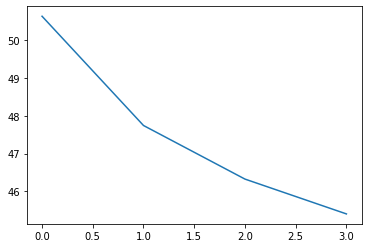

In [44]:
# Plot loss
print(f"loss at epoch 1: {history.history['val_dense_2_accuracy'][0]}")
print(f"loss at epoch 5: {history.history['val_dense_2_accuracy'][EPOCHS-2]}")
print(f"loss at epoch 10: {history.history['val_dense_2_accuracy'][EPOCHS-1]}")
plt.plot(history.history['val_loss'])

In [55]:
# Save model and weights
model.save('trained_model')
model.save_weights("trained_weights")

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


In [51]:
with open('./trained_model/trainHistoryDict.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

## Sampling Model 2: force 1st word

We first define a model that uses each step prediction as the input for next step

In [35]:
def sentence_inference_model2(LSTM_cell, densor, Ty=30):
    """
    Uses the trained "LSTM_cell" and "densor" from model() to generate a sequence of values.
    
    Arguments:
    LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    densor -- the trained "densor" from model(), Keras layer object
    Ty -- integer, number of time steps to generate
    
    Returns:
    inference_model -- Keras model instance
    """
    
    # Get the shape of input values
    n_values = densor.units
    # Get the number of the hidden state vector
    n_a = LSTM_cell.units
    
    # Define the input of your model with a shape 
    x0 = Input(shape=(1, n_values))
    x1 = Input(shape=(n_values))
    
    
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = x0

    ### START CODE HERE ###
    # Step 1: Create an empty list of "outputs" to later store your predicted values (≈1 line)
    outputs = []
    
    # Step 2: Loop over Ty and generate a value at every time step
    for t in range(Ty):
        # Step 2.A: Perform one step of LSTM_cell. Use "x", not "x0" (≈1 line)
        a, _, c = LSTM_cell(x, initial_state=[a,c])
        
        # Step 2.B: Apply Dense layer to the hidden state output of the LSTM_cell (≈1 line)
        out = densor(a)
        # Force first word to the one given
        if t == 0:
            out = tf.cast(x1, tf.int32)
        # Step 2.C: Append the prediction "out" to "outputs". out.shape = (None, n_values) (≈1 line)
        outputs.append(out)
 
        # Step 2.D: 
        # Select the next value according to "out",
        # Set "x" to be the one-hot representation of the selected value
        # See instructions above.
        x = tf.math.argmax(out, axis=-1)
        x = tf.one_hot(x,n_values)
        # Step 2.E: 
        # Use RepeatVector(1) to convert x into a tensor with shape=(None, 1, n_values)
        x = RepeatVector(1)(x)
        
    # Step 3: Create model instance with the correct "inputs" and "outputs" (≈1 line)
    inference_model = Model(inputs=[x0,x1,a0,c0], outputs=outputs)
    
    ### END CODE HERE ###
    
    return inference_model

In [36]:
inference_model2 = sentence_inference_model2(LSTM_cell, densor, Ty = 30)

We use previous model to sample ('predict') a sequence

In [34]:
x_initializer = np.zeros((1, 1, n_values))
x1 = np.zeros((1, n_values))
a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

In [37]:
def predict_and_sample2(inference_model2, x_initializer = x_initializer, x1 = x1, a_initializer = a_initializer, 
                       c_initializer = c_initializer):
    """
    Predicts the next value of values using the inference model.
    
    Arguments:
    inference_model -- Keras model instance for inference time
    x_initializer -- numpy array of shape (1, 1, n_values), one-hot vector initializing the values generation
    a_initializer -- numpy array of shape (1, n_a), initializing the hidden state of the LSTM_cell
    c_initializer -- numpy array of shape (1, n_a), initializing the cell state of the LSTM_cel
    
    Returns:
    results -- numpy-array of shape (Ty, 90), matrix of one-hot vectors representing the values generated
    indices -- numpy-array of shape (Ty, 1), matrix of indices representing the values generated
    """
    
    n_values = x_initializer.shape[2]
    
    ### START CODE HERE ###
    # Step 1: Use your inference model to predict an output sequence given x_initializer, a_initializer and c_initializer.
    pred = inference_model2.predict([x_initializer, x1, a_initializer, c_initializer])
    # Step 2: Convert "pred" into an np.array() of indices with the maximum probabilities
    indices = np.argmax(pred, axis=-1)
    # Step 3: Convert indices to one-hot vectors, the shape of the results should be (Ty, n_values)
    results = to_categorical(indices, num_classes=x_initializer.shape[2])
    ### END CODE HERE ###
    
    return results, indices

## Sample using model 2 (from a given word or taken at random)

In [38]:
x_initializer = np.zeros((1, 1, n_values))

# Force first word
init = np.zeros((1, n_values))
init[0,word_to_ix['remove']] = 1
x1 = init

a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

In [39]:
x_initializer = np.zeros((1, 1, n_values))

# Take first word at random
init = np.zeros((1, n_values))
random_word_index = np.random.choice(np.arange(n_values), p=first_word_freq)
print(random_word_index, ix_to_word[random_word_index])

init[0,random_word_index] = 1
x1 = init

a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

1112 adjust


In [40]:
results, indices = predict_and_sample2(inference_model2, x_initializer, x1, a_initializer, c_initializer)

#print("np.argmax(results[12]) =", np.argmax(results[0]))
#print("np.argmax(results[17]) =", np.argmax(results[17]))
#print("list(indices[12:18]) =", list(indices[12:18]))

# Transform the result to an actual sentence
sample_sentence_words = [ix_to_word[int(index)] for index in list(indices)]
sample_sentence = ' '.join(sample_sentence_words)
sample_sentence = sample_sentence[0].upper() + sample_sentence[1:]
print(sample_sentence)

Adjust the applicable access panel part <eos>                       
